# Echo tests

In [3]:
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import qiskit
from qiskit._accelerate import circuit_library
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [4]:
ibm_computer: str = "ibm_kyiv"
qubits = [115, 116, 117, 118, 119, 120]
depths = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
nshots: int = 10_000

In [5]:
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

In [6]:
to_run = []

for depth in depths:
    circuit = qiskit.QuantumCircuit._from_circuit_data(circuit_library.quantum_volume(len(qubits), depth, seed=1))
    compiled = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=qubits,
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=3,
    )
    compiled = compiled.compose(compiled.inverse())
    compiled = qiskit.transpile(
        compiled, 
        backend=computer,
        optimization_level=0,
    )
    if depth == 0:
        compiled.id(qubits)
    compiled.measure_active()
    assert list(AerSimulator().run(compiled).result().get_counts().keys())[0] == "0" * len(qubits)
    to_run.append(compiled)

In [7]:
# job = sampler.run(to_run, shots=nshots)
job = service.job("cuki37mvaprs73fqqui0")

In [8]:
all_counts = [result.data.measure.get_counts() for result in job.result()]
survival_probs = [counts.get("0" * len(qubits), 0) / nshots for counts in all_counts]

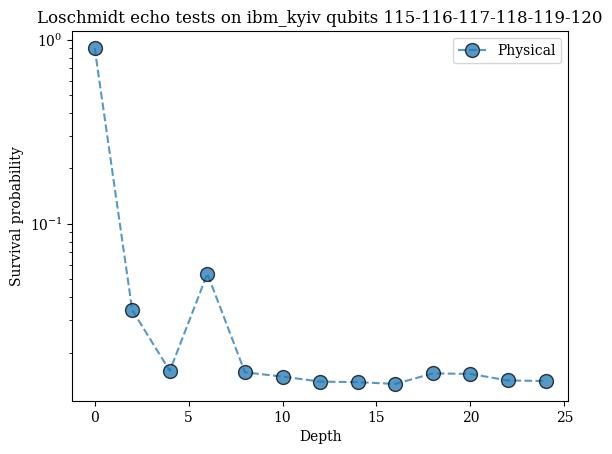

In [9]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.75, label="Physical")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));

## With dynamical decoupling

In [10]:
sampler_dd = Sampler(computer)
sampler_dd.options.dynamical_decoupling.enable = True
sampler_dd.options.dynamical_decoupling.sequence_type = "XpXm"

In [11]:
# job_dd = sampler_dd.run(to_run, shots=nshots)
job_dd = service.job("cuki416vaprs73fqr0sg")

In [12]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]
survival_probs_dd = [counts.get("0" * len(qubits), 0) / nshots for counts in all_counts_dd]

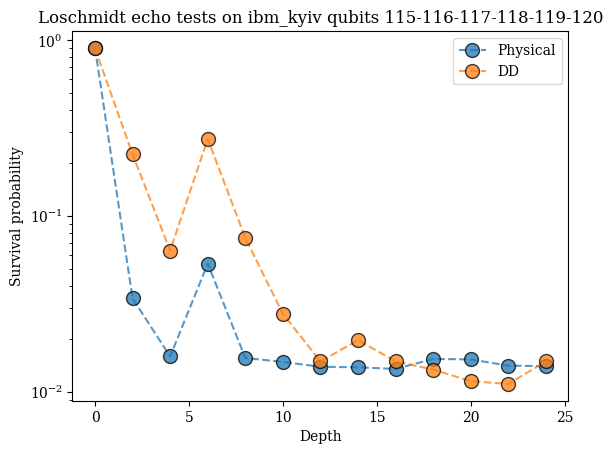

In [13]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.75, label="Physical")
plt.semilogy(depths, survival_probs_dd, "--o", ms=10, mec="black", alpha=0.75, label="DD")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));

## With readout error mitigation

In [14]:
from qiskit_experiments.library import LocalReadoutError

In [15]:
experiment = LocalReadoutError(qubits)
result = experiment.run(computer)

In [17]:
mitigator = result.analysis_results("Local Readout Mitigator").value

In [18]:
def apply_rem(counts: dict[str, int], mitigator: "qiskit_experiments.LocalReadoutMitigator") -> dict[str, int]:
    mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
    mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())
    return {k: round(v * nshots) for k, v in mitigated_probs.items()}

In [19]:
all_counts_rem = [apply_rem(counts, mitigator) for counts in all_counts]
survival_probs_rem = [counts.get("0" * len(qubits), 0) / sum(counts.values()) for counts in all_counts_rem]

In [20]:
all_counts_dd_rem = [apply_rem(counts, mitigator) for counts in all_counts_dd]
survival_probs_dd_rem = [counts.get("0" * len(qubits), 0) / sum(counts.values()) for counts in all_counts_dd_rem]

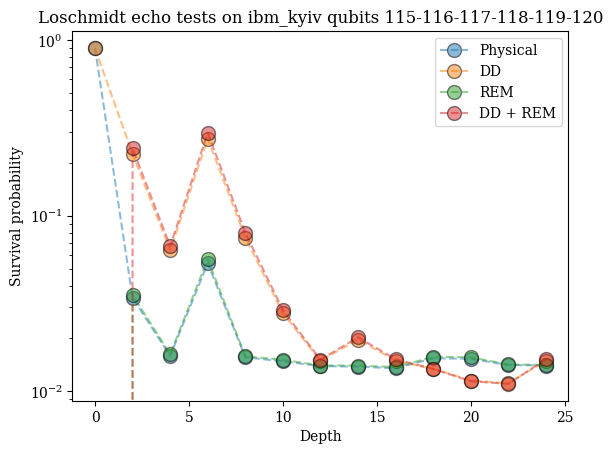

In [21]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.5, label="Physical")
plt.semilogy(depths, survival_probs_dd, "--o", ms=10, mec="black", alpha=0.5, label="DD")
plt.semilogy(depths, survival_probs_rem, "--o", ms=10, mec="black", alpha=0.5, label="REM")
plt.semilogy(depths, survival_probs_dd_rem, "--o", ms=10, mec="black", alpha=0.5, label="DD + REM")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));

## With calibration

In [22]:
import collections

import numpy as np
from scipy.optimize import curve_fit

In [23]:
to_run[1].count_ops()

OrderedDict([('rz', 844),
             ('sx', 242),
             ('ecr', 96),
             ('x', 10),
             ('measure', 6),
             ('barrier', 1)])

## (1) Run calibration circuits to determine coherent error

In [27]:
calibration_depths = list(range(0, 100 + 1, 2))

calibration_circuits = []
for cdepth in calibration_depths:
    qreg = qiskit.QuantumRegister(len(qubits))
    calibration = qiskit.QuantumCircuit(qreg)
    for _ in range(cdepth):
        calibration.sx(qreg)
    # print(calibration.draw(fold=-1))
    if cdepth == 0:
        calibration.id(qreg)
    calibration.measure_active()
    compiled = qiskit.transpile(
        calibration,
        backend=computer,
        initial_layout=qubits,
        optimization_level=0,
    )
    calibration_circuits.append(compiled)

In [32]:
job_calibration = sampler.run(calibration_circuits, shots=nshots)
# job_calibration = service.job("cukfckm0uq1s73bi7kt0")

In [33]:
all_counts_calibration = [result.data.measure.get_counts() for result in job_calibration.result()]

In [37]:
all_counts_calibration[0]

{'000000': 9267,
 '001000': 19,
 '100000': 365,
 '000100': 251,
 '010000': 6,
 '110000': 1,
 '000001': 32,
 '100100': 12,
 '000010': 42,
 '001100': 1,
 '100010': 3,
 '000110': 1}

In [48]:
def get_counts_for(qubit: int, qubits: list[int], counts: dict[str, int]) -> dict[str, int]:
    qubit_counts = collections.Counter()
    for k, v in counts.items():
        qubit_counts[k[qubits.index(qubit)]] += v
    return dict(qubit_counts)


In [49]:
for counts_calibration in all_counts_calibration:
    for qubit in qubits:
        assert sum(get_counts_for(qubit, qubits, counts_calibration).values()) == nshots

In [50]:
qubit_counts = {
    q: [get_counts_for(q, qubits, counts_calibration).get("0", 0) / nshots for counts_calibration in all_counts_calibration]
    for q in qubits
}

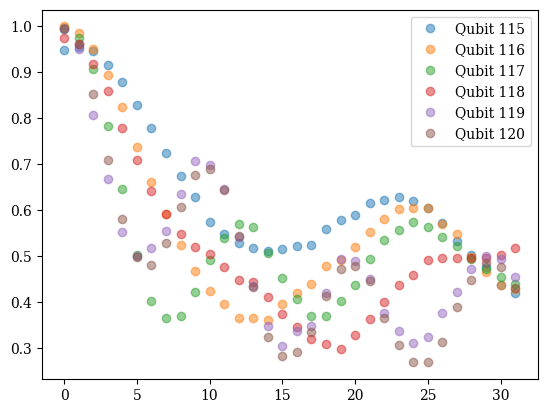

In [83]:
for q in qubits:
    plt.plot(qubit_counts[q], "o", label=f"Qubit {q}", alpha=0.5)
plt.legend();

In [52]:
def fit(xs, a=1.0, phi=0.0):
    return (a * np.cos(xs * (np.pi - phi) / 2) + 1) / 2

In [58]:
xdim = int(np.ceil(np.sqrt(len(qubits))))
ydim = int(np.floor(np.sqrt(len(qubits))))

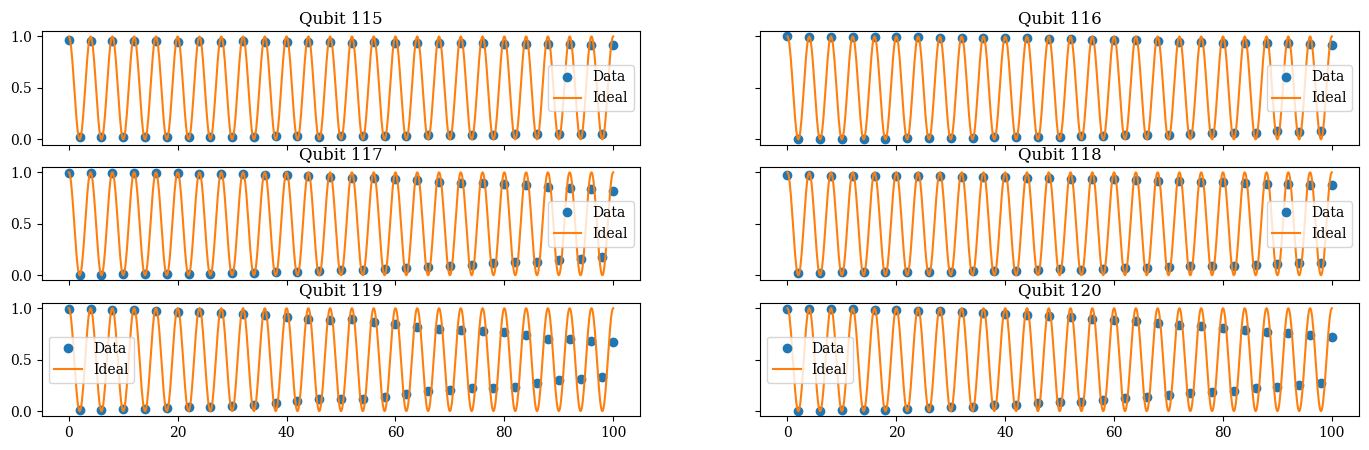

In [63]:
fig, axes = plt.subplots(xdim, ydim, sharex=True, sharey=True, figsize=(17, 5))
axes = axes.flatten()

xvals = calibration_depths

for i, qubit in enumerate(qubits):
    axes[i].plot(xvals, qubit_counts[qubit], "o", label="Data")

    xs = np.linspace(xvals[0], xvals[-1], 1000)
    axes[i].plot(xs, fit(xs), label="Ideal")
    axes[i].set_title(f"Qubit {qubit}")
    axes[i].legend()

In [64]:
phis = {}
for qubit in qubits:
    (a_opt, phi_opt), *_ = curve_fit(fit, xvals, qubit_counts[qubit], p0=[1.0, 0.0])
    phis[qubit] = phi_opt
phis

{115: np.float64(0.008244984564490788),
 116: np.float64(0.011647753833445872),
 117: np.float64(0.017327175554410153),
 118: np.float64(0.013349840835560312),
 119: np.float64(0.02509955762885478),
 120: np.float64(0.022429150939663463)}

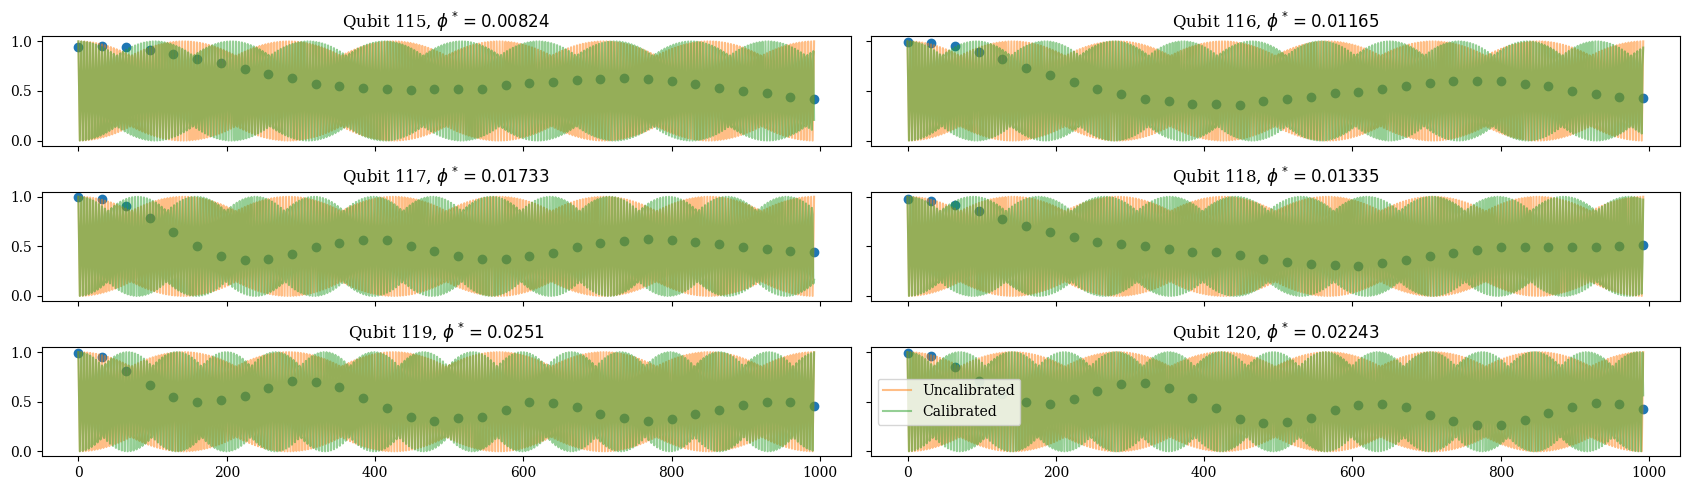

In [82]:
fig, axes = plt.subplots(xdim, ydim, sharex=True, sharey=True, figsize=(17, 5))
axes = axes.flatten()

xvals = calibration_depths

for i, qubit in enumerate(qubits):
    axes[i].plot(xvals, qubit_counts[qubit], "o")

    xs = np.linspace(xvals[0], xvals[-1], 1000)
    axes[i].plot(xs, fit(xs), alpha=0.5, label="Uncalibrated")
    axes[i].plot(xs, fit(xs, phi=phis[qubit]), alpha=0.5, label="Calibrated")
    axes[i].set_title(f"Qubit {qubit}, $\phi^* = {round(phis[qubit], 5)}$")

plt.tight_layout()
plt.legend();

## (2) Apply correction to circuits

In [66]:
def calibrate_sx(circuit: qiskit.QuantumCircuit, correction_angle: dict[int, float]) -> qiskit.QuantumCircuit:
    """Applies the per-qubit correction angle to square-root of NOT gates in the circuit,
    returning a new circuit.
    
    Args:
        circuit: Circuit to calibrate SX gates in.
        correction_angle: A dictionary of SX correction angles per qubit.
    """
    calibrated = circuit.copy_empty_like()

    for instruction in circuit.data:
        if instruction.name == "sx":
            qubit = instruction.qubits[0]._index
            calibrated.append(
                qiskit.circuit.CircuitInstruction(
                    qiskit.circuit.library.RXGate((np.pi + correction_angle[qubit]) / 2),
                    qubits=instruction.qubits,
                    clbits=instruction.clbits
                )
            )
        else:
            calibrated.append(instruction)
    return calibrated

## (3) Run benchmarks with calibrated gates

In [68]:
calibration_depths = list(range(0, 1000 + 1, 32))

calibration_circuits = []
for cdepth in calibration_depths:
    qreg = qiskit.QuantumRegister(len(qubits))
    calibration = qiskit.QuantumCircuit(qreg)
    for _ in range(cdepth):
        calibration.sx(qreg)
    # print(calibration.draw(fold=-1))
    if cdepth == 0:
        calibration.id(qreg)
    calibration.measure_active()
    compiled = qiskit.transpile(
        calibration,
        backend=computer,
        initial_layout=qubits,
        optimization_level=0,
    )
    calibration_circuits.append(compiled)

In [69]:
job_uc = sampler.run(calibration_circuits, shots=nshots)

In [72]:
all_counts_uc = [result.data.measure.get_counts() for result in job_uc.result()]

In [73]:
qubit_counts = {
    q: [get_counts_for(q, qubits, counts_calibration).get("0", 0) / nshots for counts_calibration in all_counts_uc]
    for q in qubits
}

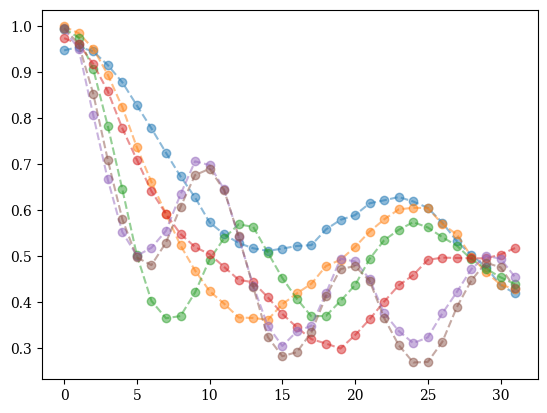

In [74]:
for q in qubits:
    plt.plot(qubit_counts[q], "--o", label=f"Qubit {q}", alpha=0.5)

In [70]:
calibrated_circuits = []
for circuit in calibration_circuits:
    calibrated = calibrate_sx(circuit, phis)
    calibrated = qiskit.transpile(
        calibrated,
        backend=computer,
        optimization_level=0,
    )
    calibrated_circuits.append(calibrated)

In [71]:
job_c = sampler.run(calibrated_circuits, shots=nshots)

In [75]:
all_counts_c = [result.data.measure.get_counts() for result in job_c.result()]

In [76]:
qubit_counts_c = {
    q: [get_counts_for(q, qubits, counts_calibration).get("0", 0) / nshots for counts_calibration in all_counts_c]
    for q in qubits
}

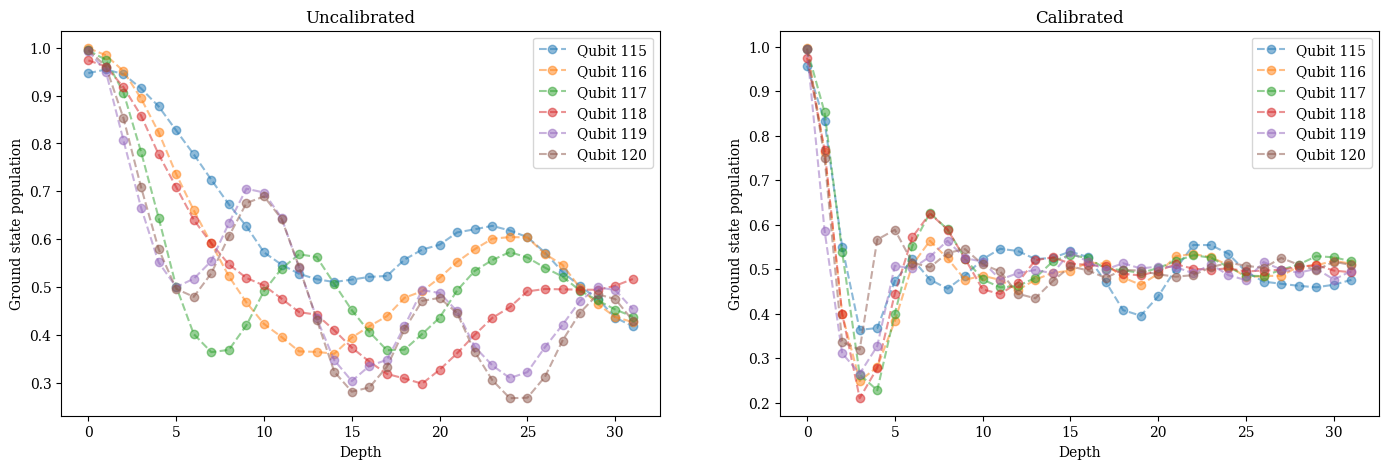

In [77]:
plt.figure(figsize=(17, 5))
plt.subplot(121)
for q in qubits:
    plt.plot(qubit_counts[q], "--o", label=f"Qubit {q}", alpha=0.5)
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Ground state population")
plt.title("Uncalibrated");

plt.subplot(122)
for q in qubits:
    plt.plot(qubit_counts_c[q], "--o", label=f"Qubit {q}", alpha=0.5)
plt.legend()
plt.xlabel("Depth")
plt.ylabel("Ground state population")
plt.title("Calibrated");

### (3.2) Quantum volume echo

In [78]:
to_run_calibrated = [
    qiskit.transpile(calibrate_sx(circuit, phis), backend=computer, optimization_level=0) for circuit in to_run
]

In [79]:
job_calibrated = sampler.run(to_run_calibrated, shots=nshots)

In [80]:
all_counts_calibrated = [result.data.measure.get_counts() for result in job_calibrated.result()]
survival_probs_calibrated = [counts.get("0" * len(qubits), 0) / nshots for counts in all_counts_calibrated]

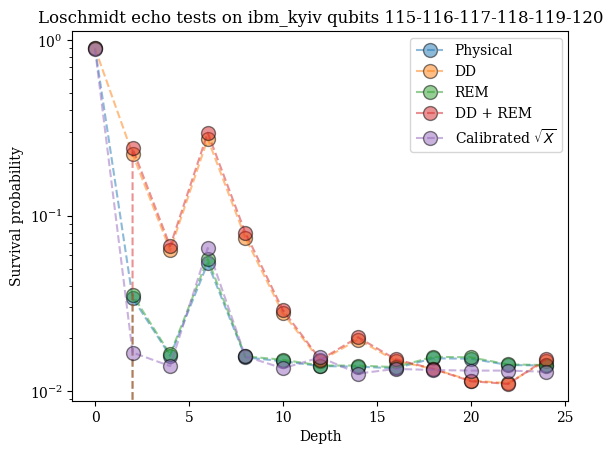

In [81]:
plt.semilogy(depths, survival_probs, "--o", ms=10, mec="black", alpha=0.5, label="Physical")
plt.semilogy(depths, survival_probs_dd, "--o", ms=10, mec="black", alpha=0.5, label="DD")
plt.semilogy(depths, survival_probs_rem, "--o", ms=10, mec="black", alpha=0.5, label="REM")
plt.semilogy(depths, survival_probs_dd_rem, "--o", ms=10, mec="black", alpha=0.5, label="DD + REM")
plt.semilogy(depths, survival_probs_calibrated, "--o", ms=10, mec="black", alpha=0.5, label=r"Calibrated $\sqrt{X}$")
plt.xlabel("Depth")
plt.ylabel("Survival probability")
plt.legend()
plt.title(f"Loschmidt echo tests on {ibm_computer} qubits " + "-".join(map(str, qubits)));